In [401]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
import random
import numpy as np
from collections import deque
import time
from keras.layers.normalization import BatchNormalization
import json
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot
from keras.layers.wrappers import TimeDistributed
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import InputLayer
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf
import pickle
from operator import itemgetter
import sys
sys.path.insert(0, '../src/data')
import auxiliary_functions, make_dataset
from auxiliary_functions import convert_miles_to_minutes_nyc, list_of_output_predictions_to_direction
sys.path.insert(0, '../src/models-DQN')
from model_mlp import RLNYCTaxiCab
from model_lstm import RLNYCTaxiCabLargeNetwork_LSTM
sys.path.insert(0,'../src/models-Actor-Critic')
from mlp_actor_critic import ActorCriticNYCMLP
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.pyplot as plt
import numpy as np
from algorithm_comparisons import AlgorithmComparison

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# How to maximize the daily revenue of taxicab drivers in NYC
- Imagine you are a driver in NYC, you can start your day anywhere and at any time. What is the best way to make the most money? Do you use heuristics that you've learned such as Manhattan is typically busy between 8am and 10am, or can we use a reinforcement learning algorithm to perform better than this appraoch?

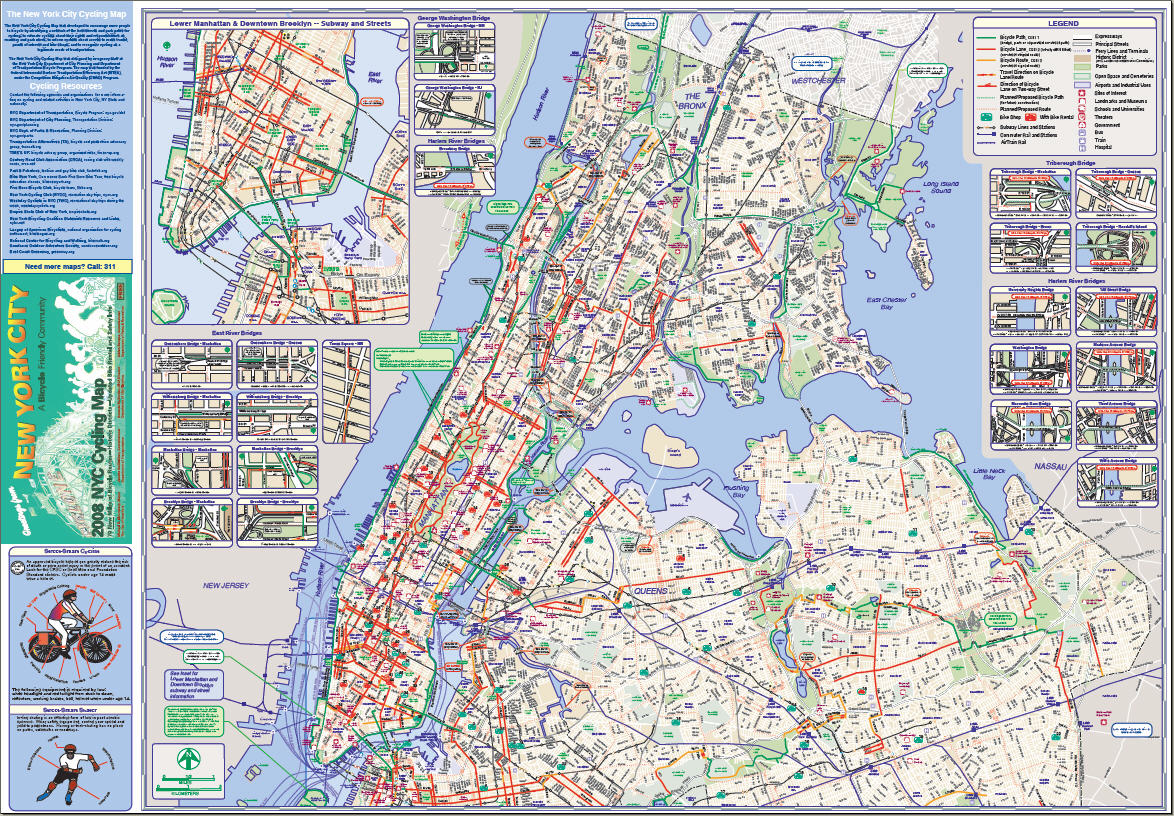

In [404]:
Image("../figures/nyc_map.jpg", embed=True)

#<img src = "../figures/nyc_map.jpg">
IPython.display.Image("../figures/nyc_map.jpg")
    - Source : http://www.nycbikemaps.com/wp-content/uploads/2008/04/2008-map-top.jpg

### Taxi cab driver data taken from 
- http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
- For this analysis, ONLY the month of January was used

### The goal of this project is to train two different reinforcement learning algorithms in an attempt to maximize the daily revenue of a driver in NYC.
- Two algorithms were used. A deep q-learning algorithm which is a type of value based algorithm. Code inspired from https://yanpanlau.github.io/2016/07/10/FlappyBird-Keras.html. Deep q-learning attemps to determine the long-run utility (or reward) associated with each potential move that a reinforcement learning algorithm could take. This q-function ,below, is approximates by a neural network where the weights are trained over time to determine the best moves to make.
<img src ="../figures/Q-learning.png">
    - Source: http://reducing-suffering.org/wp-content/uploads/2015/01/Q-learning-with-labels.png

- In addition, an Actor-Critic model was used which is a blend of a value based and policy based reinforcment learning algorithm was used. Code was inspired from http://www.rage.net/~greg/2016-07-05-ActorCritic-with-OpenAI-Gym.html. In this model, the actor model is the same as the model used for the deep q-learning algorithm above. However, this time there is also a critic that looks at each move that the critic network makes, and provides a 'critique' for the move (by assigning a value to the move based upon the temporal difference between the last and current move).
<img src = "../figures/Actor-critic-model.png">
    - Source : https://www.google.com/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=0ahUKEwjqh8v65d7TAhULxmMKHY3jBEMQjRwIBw&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2F220670783_fig1_Figure-1-Actor-critic-model&psig=AFQjCNGelF5VUKpncOsUsTVcsR5GzVX_eg&ust=1494281343434416

- The Critic network relies on a temporal difference eror that is passed along to the actor netowkr to encourage/discourage different moves.
   <img src = "../figures/Actor-Critic_Reinforcement_Learning_Equation.png">
     - Source: http://www.jianshu.com/p/03cf10cbf93a

# Overview of the different reinforcement learning approaches
<img src ="../figures/types_of_rl_algorithms.png">
     - Source : https://yanpanlau.github.io/img/torcs/actor-critic.png

### Open up our data source

In [2]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df, final_data_structure= make_dataset.main()

Opening up data
Group data
Creating the final data structure


In [392]:
# sample of the final data structure time follow by geohash picked followed by a tuple of fare, trip time, fare / time
final_data_structure[110]['Zct8R']

[(16.83410256410256, 20, 0.8417051281630428),
 (13.568571428571431, 20, 0.6784285713946502),
 (14.903888888888885, 20, 0.7451944444071845),
 (10.573636363636364, 10, 1.0573636362579),
 (10.49, 10, 1.0489999998951),
 (20.28375, 30, 0.6761249999774626),
 (13.92863636363637, 20, 0.696431818146997),
 (16.45078947368421, 20, 0.8225394736430836),
 (13.979999999999984, 20, 0.6989999999650492),
 (15.232596153846146, 20, 0.7616298076542258),
 (15.092857142857143, 20, 0.754642857105125),
 (20.539166666666667, 30, 0.6846388888660676),
 (17.402000000000005, 20, 0.8700999999564952),
 (15.51435897435897, 20, 0.7757179486791626),
 (13.809361702127658, 20, 0.6904680850718595),
 (13.942340425531903, 20, 0.6971170212417392),
 (14.408556701030914, 20, 0.7204278350155243),
 (13.827368421052636, 20, 0.6913684210180634),
 (19.789, 30, 0.6596333333113455),
 (14.559600000000003, 20, 0.7279799999636012),
 (14.088717948717953, 20, 0.7044358974006758),
 (13.443913043478263, 20, 0.6721956521403034),
 (13.97972602

In [10]:
taxi_yellowcab_df = taxi_yellowcab_df.drop('geohas_dropoff', axis=1)

In [11]:
# the data
taxi_yellowcab_df.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,jan_day,jan_minute,geohash_dropoff,trip_time_minutes
0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,...,0.5,0.0,0.0,0.3,8.8,Zct8X,1,0,dr5rsx,10
1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,...,0.5,0.0,0.0,0.3,19.3,Zct8c,1,0,dr5rtk,30
2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,...,0.5,0.0,0.0,0.3,34.3,Zct5T,1,0,dr72j1,60
3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,...,0.5,0.0,0.0,0.3,17.3,Zct8Q,1,0,dr5rkc,30
4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,...,0.5,0.0,0.0,0.3,8.8,Zc4oK,1,0,dr5rue,10
5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,...,0.5,0.0,0.0,0.3,20.3,Zct9J,1,18,dr5ryh,30
6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,...,0.5,0.0,0.0,0.3,27.3,Zct8Q,1,26,dr72hc,40
7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,...,0.5,0.0,0.0,0.3,10.3,Zct9J,1,11,dr5ru7,10
8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,...,0.5,0.0,0.0,0.3,19.3,Zc4oj,1,11,dr72mz,40
9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,...,0.5,0.0,0.0,0.3,12.8,Zct8R,1,11,dr5rkp,20


# Finding neighbors from a dropoff geohash
- use gh.neighbors
- Convert these neighbors to an output index from the neural network

In [6]:
gh.neighbors(taxi_yellowcab_df.geohash_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

In [7]:
# Dictionary to convert these distances into the output from the Neural Network
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
list_of_output_predictions_to_direction={0:'nw',1:'n',2:'ne',3:'w',4:'stay',5:'e',6:'sw',7:'s',8:'se'}

# How many different paths are there for a cab driver to take
- 1) Assuming you can go to every geohash (not possible)
- 2) In a day

In [8]:
print('There are {} possible moves per day - increments of 10 minutes'.format(6*24))

There are 144 possible moves per day - increments of 10 minutes


In [9]:
# how man geohashes can you visit in a day?
print('WIth a full 24 hours day, you can visit {:,} geohashes with an average time of 10 minutes to traverse'.format(
    9**(144+1)-1))

WIth a full 24 hours day, you can visit 2,318,269,218,083,089,908,234,280,468,459,894,595,445,540,070,540,355,238,386,428,052,606,631,732,586,480,323,016,481,331,702,297,098,820,479,338,186,895,528,168,360,391,078,014,797,448 geohashes with an average time of 10 minutes to traverse


In [10]:
len(str(9**(144+1)-1))

139

# Heat Map of the most profitable geohashes

In [11]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [12]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [13]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [14]:
# can only plot 2k values on google maps

In [15]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

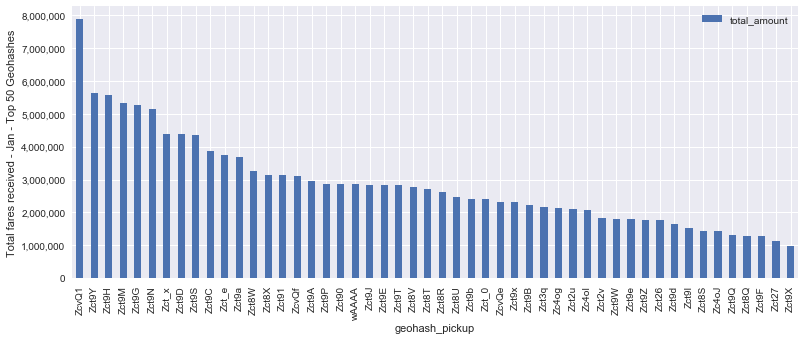

In [16]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

In [16]:
# See where the top geohashes are
gh.decode('ZcvQ1') ## JFK airport number 1

{'h': 0.005493, 'lat': 40.646667, 'lon': -73.778686, 'w': 0.010986}

In [17]:
gh.decode('Zct9Y') ## next to trump tower in manhattan

{'h': 0.005493, 'lat': 40.762023, 'lon': -73.97644, 'w': 0.010986}

In [18]:
gh.decode('Zct9H')

{'h': 0.005493, 'lat': 40.75653, 'lon': -73.987426, 'w': 0.010986}

## Break up the day into ten minute intervals( the time to traverse a geohash of ~3803 meters).
### Note: This code is already run in the make_data.main() call in the first cell
- Aggregate all of the days together so that you have one 24 hour block
- For this 24 hour block, group by five minute periods
- For each period, take the geohash as the key and a list of tuples of ( average fares over the month, trip times in minutes)
- This gives an end result of the average fare and corresponding trip time and ration of fare/trip time for each geohash for a given ten minutes over each day in January

In [13]:

    
taxi_yellowcab_df['trip_time_minutes'] = taxi_yellowcab_df.trip_distance.apply(lambda x: convert_miles_to_minutes_nyc(x))

In [14]:
# distribution of trip times
trip_minutes_grouped = taxi_yellowcab_df.groupby('trip_time_minutes').count()

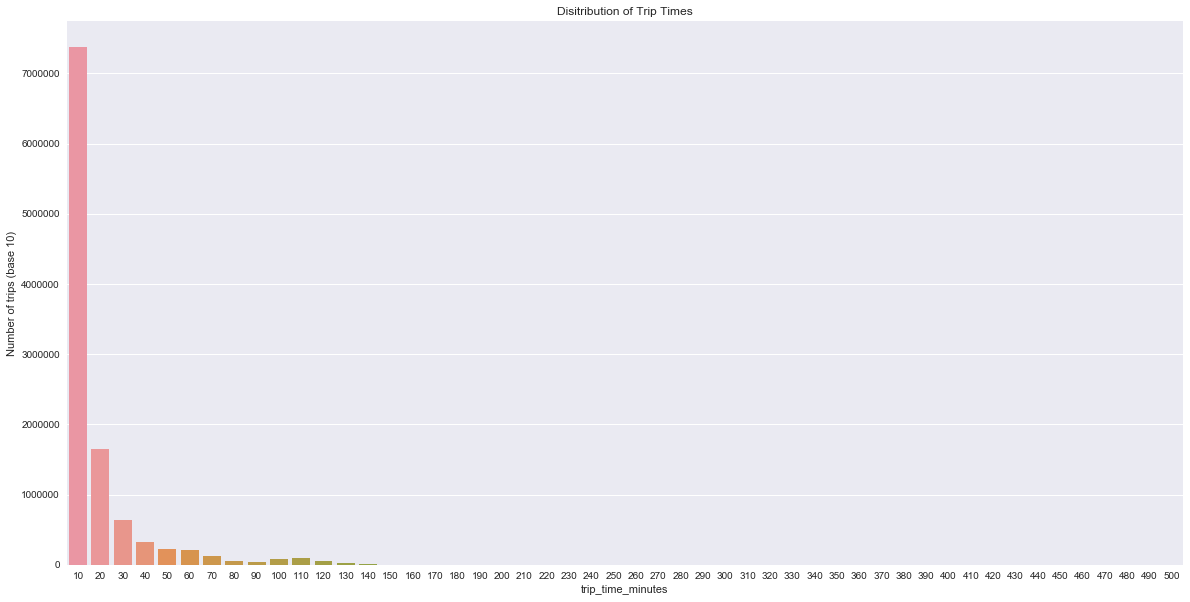

In [15]:
plt.figure(figsize=(20,10))
grid = sns.barplot(x = trip_minutes_grouped['VendorID'].reset_index()['trip_time_minutes'][:50],
            y= trip_minutes_grouped['VendorID'].reset_index()['VendorID'][:50])
#grid.set( yscale="log")
plt.ylabel('Number of trips (base 10)')
plt.title('Disitribution of Trip Times')

## Index the geohashes to a number, also a number to a geohash.
#### List of possible times
- This is how we feed in to geohashes into our neural network

In [3]:
## get a list of unique geohashes
list_of_unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(list_of_unique_geohashes)

3086

In [4]:
list_of_geohash_index  = defaultdict(int)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_geohash_index [hash_n] = idx

In [5]:
list_of_inverse_heohash_index = defaultdict(str)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_inverse_heohash_index[idx] = hash_n

In [6]:
hours = [str(_) for _ in range(24)]
minutes = [str(_) for _ in range(0,60,10)]
minutes.append('00')
list_of_time_index =[]
for h in hours:
    for m in minutes:

        list_of_time_index.append(int(str(h)+str(m)))
list_of_time_index = list(set(list_of_time_index))

In [7]:
taxi_yellowcab_df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'geohash_pickup', 'geohas_dropoff', 'jan_day', 'jan_minute',
       'geohash_dropoff', 'trip_time_minutes'],
      dtype='object')

# Hyperas results for MLP-DQN model

```python
model_mlp = Sequential()
model_mlp.add(Dense({{choice([32, 64,126, 256, 512, 1024])}},
                        activation='relu', input_shape= (2,)))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense(9))
model_mlp.add(Activation({{choice(['softmax','linear'])}}))
model_mlp.compile(loss={{choice(['categorical_crossentropy','mse'])}}, metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})```



> model_mlp.fit(x_train, y_train,
              batch_size={{choice([16, 32, 64, 128])}},
              epochs=50,
              verbose=2,
              validation_data=(x_test, y_test))
    score, acc = model_mlp.evaluate(x_test, y_test, verbose=0)




>Best performing model chosen hyper-parameters:
- {'Activation': 1, 'Activation_1': 0, 'Activation_2': 0, 'Activation_3': 0, 'Dense': 0, 'Dense_1': 1, 'Dense_2': 1, 'Dense_3': 5, 'Dropout': 0.056229870832780804, 'Dropout_1': 0.1603763880022983, 'Dropout_2': 0.3671073489296299, 'Dropout_3': 0.3462695171578595, 'batch_size': 0, 'loss': 1, 'optimizer': 2}
- Interesting, use MSE with softmax

# Hyperas results for LSTM model - DQN

```python 
model_lstm = Sequential()
model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                     batch_input_shape=(1,x_train.shape[1], 2),
                 recurrent_dropout={{uniform(0, .5)}},return_sequences = True))
model_lstm.add(BatchNormalization())
condition = conditional({{choice(['one','two','three', 'four'])}})

if condition == 'one':
    pass
elif condition == 'two':
    model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                 recurrent_dropout={{uniform(0, .5)}}))
    model_lstm.add(BatchNormalization())
elif condition  == 'three':
    model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                 recurrent_dropout={{uniform(0, .5)}}))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Dense({{choice([126, 256, 512, 1024])}}))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Activation({{choice(['relu','tanh','sigmoid'])}}))
elif condition == 'four':
    model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                 recurrent_dropout={{uniform(0, .5)}}))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Dense({{choice([126, 256, 512, 1024])}}))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Activation({{choice(['relu','tanh','sigmoid'])}}))
    model_lstm.add(Dense({{choice([126, 256, 512, 1024])}}, activation='relu'))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Activation({{choice(['relu','tanh','sigmoid'])}}))


model_lstm .add(Dense(9, activation='linear',name='dense_output'))
adam = Adam(clipnorm=.5, clipvalue=.5)
model_lstm .compile(loss='mean_squared_error', optimizer=adam)
model_lstm.summary()



```
- Results

- {'Activation': 2, 'Activation_1': 2, 'Activation_2': 0, 
- 'Dense': 2, 'Dense_1': 2, 'Dense_2': 0,
- 'LSTM': 3, 'LSTM_1': 0, 'LSTM_2': 4, 'LSTM_3': 1, 
- 'conditional': 2, 
- 'dropout': 0.24262496679483414, 'dropout_1': 0.24083776969398046, 'dropout_2': 0.4440995372232807, 'dropout_3': 0.19378913952416787, 'dropout_4': 0.18058579914657197, 'dropout_5': 0.1820122957634046, 'dropout_6': 0.11399536937803484, 'dropout_7': 0.13709791545993666}
- Three layers performed best



# MLP model architectures
### DQN
#### Note: I had to use batch norm as well as gradient clipping, limiting the norm of the gradient due to exploding gradient problems.

In [19]:
##Define a simple model where the output is a softmax probability over the eight states
# Inputs will be the time, current geohash-index ()
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
model_mlp_dqn = Sequential()
model_mlp_dqn.add(Dense(100, input_shape=(2,)))
model_mlp_dqn.add(BatchNormalization())
model_mlp_dqn.add(Activation('relu'))
model_mlp_dqn.add(Dropout(.3))
model_mlp_dqn.add(Dense(500))
model_mlp_dqn.add(BatchNormalization())
model_mlp_dqn.add(Activation('relu'))
model_mlp_dqn.add(Dropout(.3))
model_mlp_dqn.add(Dense(1000))
model_mlp_dqn.add(BatchNormalization())
model_mlp_dqn.add(Activation('relu'))
model_mlp_dqn.add(Dropout(.3))
model_mlp_dqn.add(Dense(9, activation='linear')) ## predict which geohash to move to next
adam = Adam(lr=.1)
model_mlp_dqn.compile(loss='mse',optimizer=adam)
model_mlp_dqn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               50500     
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
__________

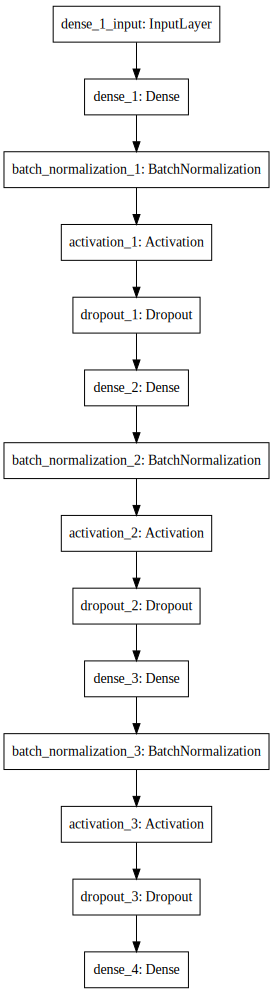

In [21]:
SVG(model_to_dot(model_mlp_dqn).create(prog='dot', format='svg'))

# LSTM model architecture - DQN
- Interesting, you don't need the time distributed dense layer. Keras implies this layer for you.

In [ ]:
sample_size = 5000
batch_sizze = 32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, None, 512)            1054720   
_________________________________________________________________
batch_normalization_10 (Batc (1, None, 512)            2048      
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           6295552   
_________________________________________________________________
batch_normalization_11 (Batc (1, None, 1024)           4096      
_________________________________________________________________
dense_13 (Dense)             (1, None, 512)            524800    
_________________________________________________________________
batch_normalization_12 (Batc (1, None, 512)            2048      
_________________________________________________________________
activation_10 (Activation)   (1, None, 512)            0         
__________

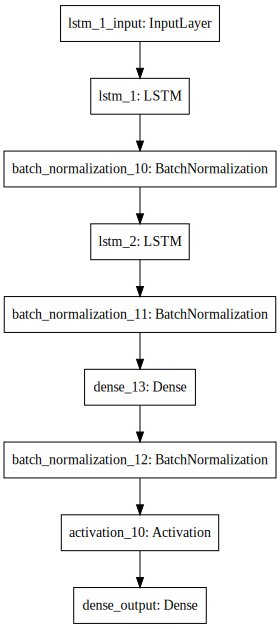

In [24]:
model_lstm_dqn = Sequential()
model_lstm_dqn .add(LSTM( 512, dropout=.24,
                     batch_input_shape=(1,None, 2),
                 recurrent_dropout=.24,return_sequences = True))
model_lstm_dqn.add(BatchNormalization())
model_lstm_dqn .add(LSTM(1024, dropout=.18,
         recurrent_dropout=.18,
         return_sequences = True))
model_lstm_dqn.add(BatchNormalization())
model_lstm_dqn.add(Dense(512))
model_lstm_dqn.add(BatchNormalization())
model_lstm_dqn.add(Activation('sigmoid'))
model_lstm_dqn .add(Dense(9, activation='linear',name='dense_output'))
adam = Adam(clipnorm=.5, clipvalue=.5)
## for the real model, I used MSE loss
model_lstm_dqn .compile(loss='mean_squared_error', optimizer=adam)
model_lstm_dqn.summary()
SVG(model_to_dot(model_lstm_dqn).create(prog='dot', format='svg'))

# MLP model architecture for Actor-Critic

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               300       
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
activation_7 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               50500     
_________________________________________________________________
batch_normalization_8 (Batch (None, 500)               2000      
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
__________

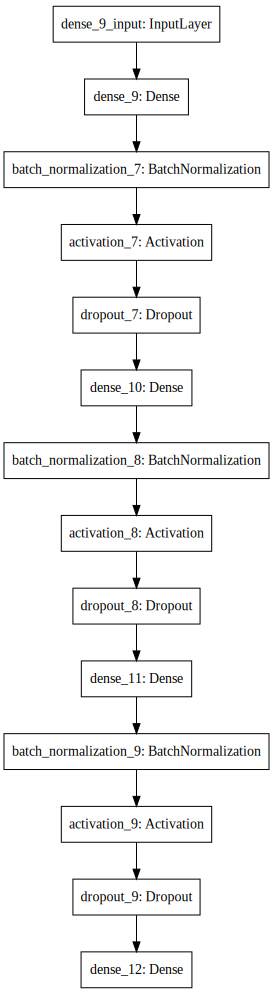

In [23]:
model_mlp_actor = Sequential()
model_mlp_actor.add(Dense(100, input_shape=(2,)))
model_mlp_actor.add(BatchNormalization())
model_mlp_actor.add(Activation('relu'))
model_mlp_actor.add(Dropout(.3))
model_mlp_actor.add(Dense(500))
model_mlp_actor.add(BatchNormalization())
model_mlp_actor.add(Activation('relu'))
model_mlp_actor.add(Dropout(.3))
model_mlp_actor.add(Dense(1000))
model_mlp_actor.add(BatchNormalization())
model_mlp_actor.add(Activation('relu'))
model_mlp_actor.add(Dropout(.3))
model_mlp_actor.add(Dense(9, activation='linear'))
adam = Adam(clipnorm=1.0)
model_mlp_actor.compile(loss='mse',optimizer=adam)
model_mlp_actor.summary()
SVG(model_to_dot(model_mlp_actor).create(prog='dot', format='svg'))

#### Note: the critic only ouputs one number which is an indication of how good the critic thinks the move make by the actor is

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               300       
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               50500     
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               2000      
_________________________________________________________________
activation_5 (Activation)    (None, 500)               0         
__________

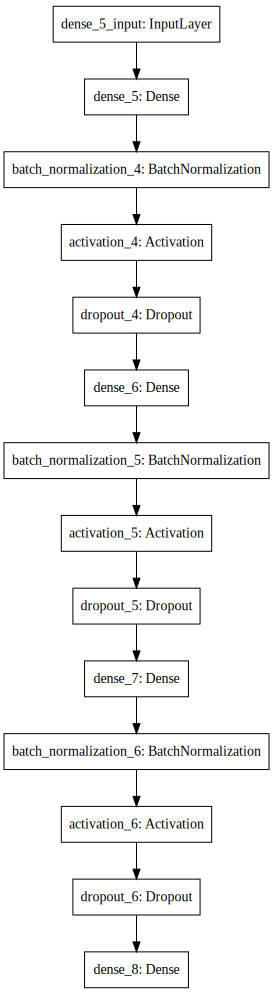

In [22]:
model_mlp_critic = Sequential()
model_mlp_critic.add(Dense(100, input_shape=(2,)))
model_mlp_critic.add(BatchNormalization())
model_mlp_critic.add(Activation('relu'))
model_mlp_critic.add(Dropout(.3))
model_mlp_critic.add(Dense(500))
model_mlp_critic.add(BatchNormalization())
model_mlp_critic.add(Activation('relu'))
model_mlp_critic.add(Dropout(.3))
model_mlp_critic.add(Dense(1000))
model_mlp_critic.add(BatchNormalization())
model_mlp_critic.add(Activation('relu'))
model_mlp_critic.add(Dropout(.3))
model_mlp_critic.add(Dense(1, activation='linear'))  # predict the value
adam = Adam(clipnorm=1.0)
model_mlp_critic.compile(loss='mse', optimizer=adam)
model_mlp_critic.summary()
SVG(model_to_dot(model_mlp_critic).create(prog='dot', format='svg'))

# Show that the model can overfit a small training set
#### DQN and Actor Critic
--- Assume that all trips are ten minutes

In [344]:
starting_geohash = 'Zc4o0'
geohash_index_1 = list_of_geohash_index['Zc4o-']
starting_time = 110

In [345]:
gh.neighbors('Zc4o0')

{'e': 'Zc4o2',
 'n': 'Zc4o1',
 'ne': 'Zc4o3',
 'nw': 'Zc4of',
 's': 'Zc4ox',
 'se': 'Zc4oz',
 'sw': 'Zc4ob',
 'w': 'Zc4oe'}

In [346]:
# options to move to
nw_1 = final_data_structure[110]['Zc4of']
n_1 =  final_data_structure[110]['Zc4o1']
ne_1 = final_data_structure[110]['Zc4o3']
w_1 = final_data_structure[110]['Zc4oe']
stay_1 = final_data_structure[110][starting_geohash]
e_1 = final_data_structure[110]['Zc4o2']
sw_1 = final_data_structure[110]['Zc4ob']
s_1 = final_data_structure[110]['Zc4ox']
se_1 = final_data_structure[110]['Zc4oz']


In [347]:
## find the best ratio of fare / time traveled
max_nw_1 = 0
max_n_1 = max(n_1,key=itemgetter(2))[2]
max_ne_1 =max(ne_1,key=itemgetter(2))[2]
max_w_1 = max(w_1,key=itemgetter(2))[2]
max_stay_1 = max(stay_1,key=itemgetter(2))[2]
max_e_1 = max(e_1,key=itemgetter(2))[2]
max_sw_1 = max(sw_1,key=itemgetter(2))[2]
max_s_1 = max(s_1,key=itemgetter(2))[2]
max_se_1 = max(se_1,key=itemgetter(2))[2]

In [348]:
## Find the optimal move
np.argmax(np.array([max_n_1,max_ne_1,max_w_1,max_stay_1,max_e_1,max_sw_1,max_s_1,max_se_1]))

0

In [349]:
max_n_1

2.679999999732

In [351]:
### Next time step
## geohash two
geohash_2 = 'Zc4o1'
geohash_index_2 = list_of_geohash_index['Zc4o1']
time_2 = 120

In [352]:
## find potential moves
gh.neighbors('Zc4o1')

{'e': 'Zc4o3',
 'n': 'Zc4pg',
 'ne': 'Zc4pi',
 'nw': 'Zc4pK',
 's': 'Zc4o0',
 'se': 'Zc4o2',
 'sw': 'Zc4oe',
 'w': 'Zc4of'}

In [353]:
# options to move to
nw_2 = final_data_structure[120]['Zc4pK']
n_2 =  final_data_structure[120]['Zc4pg']
ne_2 = final_data_structure[120]['Zc4pi']
w_2 = final_data_structure[120]['Zc4of']
stay_2 = final_data_structure[120][geohash_2]
e_2 = final_data_structure[120]['Zc4o3']
sw_2 = final_data_structure[120]['Zc4oe']
s_2 = final_data_structure[120]['Zc4o0']
se_2 = final_data_structure[120]['Zc4o2']


In [354]:
## find the best ratio of fare / time traveled, zeros indicate no fare data available 
max_nw_2 = 0
max_n_2 = max(n_2,key=itemgetter(2))[2]
max_ne_2 =max(ne_2,key=itemgetter(2))[2]
max_w_2 = 0
max_stay_2 = max(stay_2,key=itemgetter(2))[2]
max_e_2 = max(e_2,key=itemgetter(2))[2]
max_sw_2 = max(sw_2,key=itemgetter(2))[2]
max_s_2 = max(s_2,key=itemgetter(2))[2]
max_se_2 = max(se_2,key=itemgetter(2))[2]

In [355]:
## Find the optimal move
np.argmax(np.array([0,max_n_2,max_ne_2,0,max_stay_2,max_e_2,max_sw_2,max_s_2,max_se_2]))

8

In [370]:
max_se_2

2.009999999799

In [357]:
### Next time step
## geohash three
geohash_3 = 'Zc4o2'
geohash_index_3 = list_of_geohash_index['Zc4o2']
time_3 = 130

In [358]:
## find potential moves
gh.neighbors('Zc4o2')

{'e': 'Zc4o8',
 'n': 'Zc4o3',
 'ne': 'Zc4o9',
 'nw': 'Zc4o1',
 's': 'Zc4oz',
 'se': 'Zc4o5',
 'sw': 'Zc4ox',
 'w': 'Zc4o0'}

In [359]:
# options to move to
nw_3 = final_data_structure[130]['Zc4pK']
n_3 =  final_data_structure[130]['Zc4pg']
ne_3 = final_data_structure[130]['Zc4pi']
w_3 = final_data_structure[130]['Zc4of']
stay_3 = final_data_structure[130][geohash_2]
e_3 = final_data_structure[130]['Zc4o3']
sw_3 = final_data_structure[130]['Zc4oe']
s_3 = final_data_structure[130]['Zc4o0']
se_3 = final_data_structure[130]['Zc4o2']


In [362]:
## find the best ratio of fare / time traveled, zeros indicate no fare data available 
max_nw_3 = 0
max_n_3 = max(n_3,key=itemgetter(2))[2]
max_ne_3 =max(ne_3,key=itemgetter(2))[2]
max_w_3 = 0
max_stay_3 = max(stay_3,key=itemgetter(2))[2]
max_e_3 = max(e_3,key=itemgetter(2))[2]
max_sw_3 = max(sw_3,key=itemgetter(2))[2]
max_s_3 = max(s_3,key=itemgetter(2))[2]
max_se_3 = max(se_3,key=itemgetter(2))[2]

In [365]:
## Find the optimal move
np.argmax(np.array([0,max_n_2,max_ne_2,0,max_stay_2,max_e_2,max_sw_2,max_s_2,max_se_2]))

8

In [421]:
## create the training data, time followed by geohash index
x_train = np.array([[110,geohash_index_1 ],
                   [120,geohash_index_2],
                   [130, geohash_index_3]])
y_train = np.array([np.array([0,max_n_1,max_ne_1,max_w_1,max_stay_1,max_e_1,max_sw_1,max_s_1,max_se_1]),
                   np.array([0,max_n_2,max_ne_2,0,max_stay_2,max_e_2,max_sw_2,max_s_2,max_se_2]),
                   np.array([0,max_n_2,max_ne_2,0,max_stay_2,max_e_2,max_sw_2,max_s_2,max_se_2])])
x_train_lstm = x_train.reshape(1,3,2)
y_train_lstm = y_train.reshape(1,3,9)

In [384]:
x_train

array([[110, 222],
       [120, 131],
       [130, 125]])

In [385]:
y_train

array([[ 0.        ,  2.68      ,  1.416     ,  0.98      ,  1.5892    ,
         1.195     ,  1.235     ,  1.15      ,  1.13      ],
       [ 0.        ,  1.18      ,  1.33      ,  0.        ,  1.08      ,
         1.19866667,  0.935     ,  1.235     ,  2.01      ],
       [ 0.        ,  1.18      ,  1.33      ,  0.        ,  1.08      ,
         1.19866667,  0.935     ,  1.235     ,  2.01      ]])

##### train mlp, DQN first

In [405]:

loss_dqn = model_mlp_dqn.fit(x_train,y_train, epochs=500)


Epoch 1/500
3/3 [==============================] - 15s - loss: 2.8165
Epoch 2/500
3/3 [==============================] - 0s - loss: 1284.1503
Epoch 3/500
3/3 [==============================] - 0s - loss: 399.3954
Epoch 4/500
3/3 [==============================] - 0s - loss: 331.0550
Epoch 5/500
3/3 [==============================] - 0s - loss: 458.3563
Epoch 6/500
3/3 [==============================] - 0s - loss: 293.2779
Epoch 7/500
3/3 [==============================] - 0s - loss: 102.6409
Epoch 8/500
3/3 [==============================] - 0s - loss: 118.3431
Epoch 9/500
3/3 [==============================] - 0s - loss: 163.4830
Epoch 10/500
3/3 [==============================] - 0s - loss: 190.7306
Epoch 11/500
3/3 [==============================] - 0s - loss: 164.3187
Epoch 12/500
3/3 [==============================] - 0s - loss: 42.4615
Epoch 13/500
3/3 [==============================] - 0s - loss: 88.5228
Epoch 14/500
3/3 [==============================] - 0s - loss: 101.7442
Epo

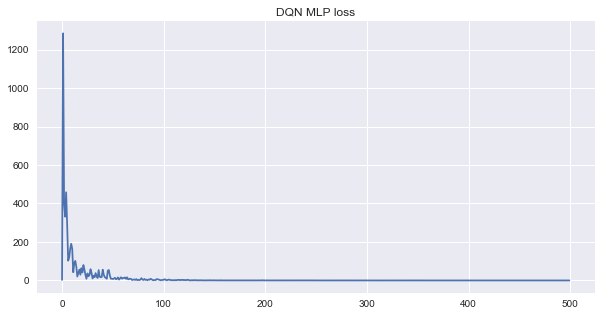

In [411]:
plt.figure(figsize=(10,5))
plt.plot(pd.DataFrame(loss_dqn.history))
plt.title('DQN MLP loss')

- COnfirm that MLP DQN  predicts the correct moves

In [415]:
# first move is correct! 
model_mlp_dqn.predict(np.array([[110,geohash_index_1]]))

array([[-0.02863249,  2.6460526 ,  1.45820236,  0.96229053,  1.58814847,
         1.20503819,  1.24276483,  1.17153418,  1.20499098]], dtype=float32)

In [417]:
# second move is correct!
model_mlp_dqn.predict(np.array([[120,geohash_index_2]]))

array([[ 0.01350954,  1.21027422,  1.39503455,  0.07417355,  1.06682491,
         1.22214079,  0.92659408,  1.25270569,  1.99638462]], dtype=float32)

In [419]:
# third move is correct!
model_mlp_dqn.predict(np.array([[130,geohash_index_3]]))

array([[ 0.0463123 ,  1.16668797,  1.16690898, -0.03184484,  1.0427134 ,
         1.15231943,  0.88123333,  1.20626962,  1.99009585]], dtype=float32)

##### Train LSTM - DQN model

In [436]:

loss_dqn_lstm = model_lstm_dqn.fit(x_train_lstm,y_train_lstm, epochs=200)


Epoch 1/200
1/1 [==============================] - 0s - loss: 2.6884e-04
Epoch 2/200
1/1 [==============================] - 0s - loss: 7.2942e-05
Epoch 3/200
1/1 [==============================] - 0s - loss: 1.0723e-04
Epoch 4/200
1/1 [==============================] - 0s - loss: 9.2737e-05
Epoch 5/200
1/1 [==============================] - 0s - loss: 7.2663e-05
Epoch 6/200
1/1 [==============================] - 0s - loss: 7.8367e-05
Epoch 7/200
1/1 [==============================] - 0s - loss: 5.6993e-05
Epoch 8/200
1/1 [==============================] - 0s - loss: 8.0032e-05
Epoch 9/200
1/1 [==============================] - 0s - loss: 6.0111e-05
Epoch 10/200
1/1 [==============================] - 0s - loss: 6.2836e-05
Epoch 11/200
1/1 [==============================] - 0s - loss: 4.9886e-05
Epoch 12/200
1/1 [==============================] - 0s - loss: 8.6477e-05
Epoch 13/200
1/1 [==============================] - 0s - loss: 1.3211e-04
Epoch 14/200
1/1 [=============================

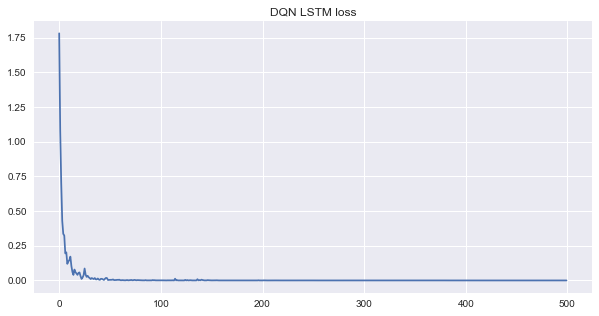

In [431]:
plt.figure(figsize=(10,5))
plt.plot(pd.DataFrame(loss_dqn_lstm.history))
plt.title('DQN LSTM loss')

-  Confirm that LSTM can predict the correct move
- takes longer to train than the MLP model. ~ 700 epochs

In [437]:
# first move is correct! 
model_lstm_dqn.predict(np.array([[[110,geohash_index_1]]]))

array([[[-0.00751675,  2.19497132,  1.35824299,  0.62839681,  1.37668848,
          1.17169845,  1.10601306,  1.191118  ,  1.43955886]]], dtype=float32)

In [438]:
# second move is correct! 
model_lstm_dqn.predict(np.array([[[120,geohash_index_2]]]))

array([[[ 0.06534243,  1.67966938,  1.34114146,  0.28505331,  1.15305519,
          1.1242348 ,  1.00437689,  1.24120104,  1.69941151]]], dtype=float32)

In [439]:
# third move is correct
model_lstm_dqn.predict(np.array([[[130,geohash_index_3]]]))

array([[[ 0.07032287,  1.66868091,  1.34628081,  0.27993026,  1.16090024,
          1.12148237,  1.01514578,  1.25166583,  1.70155454]]], dtype=float32)

#### Since actor critic requires a temporal difference, we will not attempt to overfit on this toy training example.

# What does the Q-Function look like
- DQN

Q = [ 46.7195816  , 40.35506439 , 49.85878754 , 52.6238691 ,  43.46485138,
    48.80019379 , 49.63986588,  40.81505203  45.46622467],

# GPU vs CPU

In [17]:
gpu_speed_1k = 55
cpu_speed_1k = 59


In [19]:
# How much time is saved over 1,000,000 training examples?
print('We save about {} minutes over 1 million training iterations'.format(round((1000000/1000 * \
                                                                                     (cpu_speed_1k -gpu_speed_1k ))/60)))

We save about 67 minutes over 1 million training iterations


# DQN approach

### Investigate the loss over time

In [54]:
with open(r"mlp_model_dqn/loss_over_time_linear", "rb") as input_file:
     loss_over_time_mlp = pickle.load(input_file)



In [56]:
len(loss_over_time_mlp)

995000

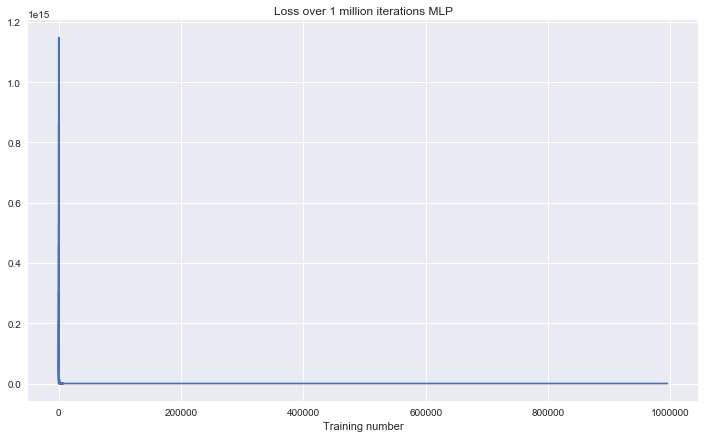

In [60]:
plt.figure(figsize=(12,7))
plt.plot(loss_over_time_mlp)
plt.title('Loss over 1 million iterations MLP')
plt.xlabel('Training number')

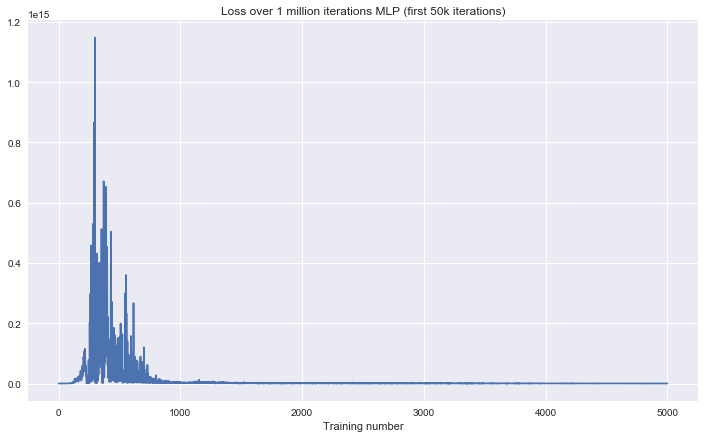

In [64]:
plt.figure(figsize=(12,7))
plt.plot(loss_over_time_mlp[:5000])
plt.title('Loss over 1 million iterations MLP (first 50k iterations)')
plt.xlabel('Training number')

- Good! The loss is decreasing as expected

# Investigate the fare earned in a naive approach vs training of each algorithm
- Each 'iteration' mentioned below corresponds to a 'move' in the grid of NYC (i.e. moving to the geohash North of where you are, or South ..etc)

In [61]:
total_fare_received_over_time_no_train = total_fare_received_over_time
naive_fare_over_time_no_train = naive_fare_over_time

### No training, fares between RL and naive

In [ ]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Test','save_model':False,'model_weights_load':'model_mlp.h5',
               'save_model_weights':'mlp_linear.h5'}# for the million parameter weights
loss_list, total_fare_received_over_time_no_train,list_of_geohashes_visited, \
naive_fare_over_time_no_train, days_driven, naive_geohashes =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

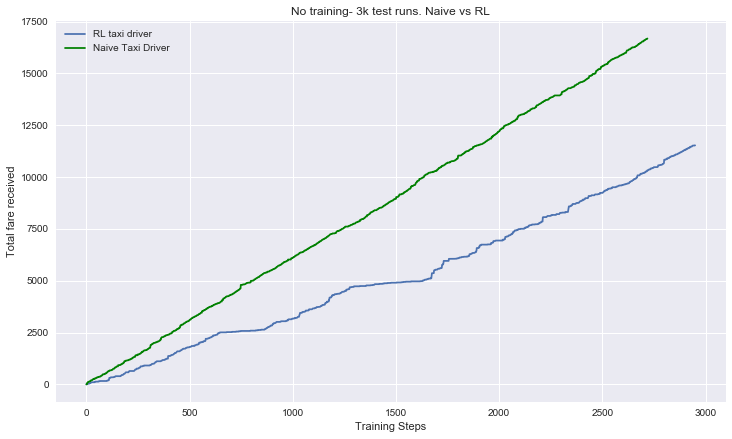

In [62]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_no_train, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_no_train, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('No training- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

## One million training iterations, fares between RL and Naive

In [39]:

    
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model_dqn/model_mlp_linear_onemillion.h5',
      'save_model_weights':'mlp_linear_1million.h5'} # for the million parameter weights

loss_list, total_fare_received_over_time_onemillion_training,list_of_geohashes_visited, \
naive_fare_over_time_onemillion_training, days_driven, naive_geohashes =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 3 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 3.3423259258270264
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 500 / STATE observe / EPSILON 0.0001 / ACTION 3 / REWARD 0.757479166629 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 1.8544049263000488
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1000 / STATE observe / EPSILON 0.0001 / ACTION 3 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 1.9710350036621094
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1500 / STATE explore / EPSILON 0.0001 / ACTION 7 / REWARD -0.1 / Q_MAX  35.3119 / Loss  0.0201441105455 / Total fare RL  2994.38877008 /

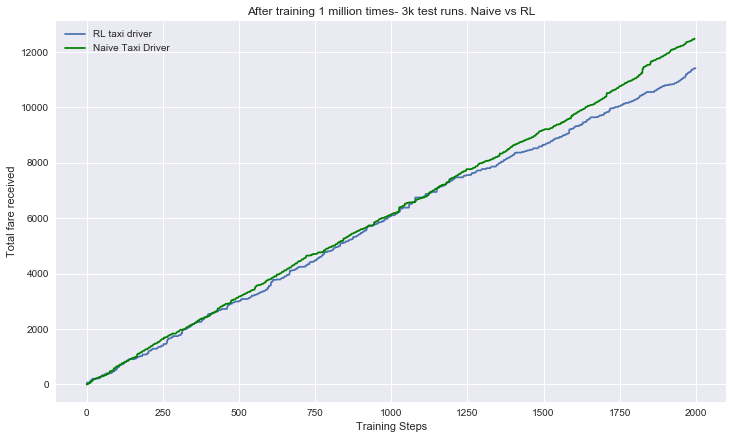

In [40]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_onemillion_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_onemillion_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 1 million times- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

### 1.5 million training iterations, fares between rl and naive, DQN MLP

In [35]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model_dqn/model_mlp_linear_1.5million.h5',
      'save_model_weights':'mlp_linear_1.5million.h5'} # for the million parameter weights


loss_list_1_5million, total_fare_received_over_time_1_5million_training,list_of_geohashes_visited_1_5million, \
naive_fare_over_time_1_5million_training, days_driven1_5million, naive_geohashes_1_5million =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 8 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 0.442213773727417
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 500 / STATE explore / EPSILON 0.0001 / ACTION 6 / REWARD 0.977999999951 / Q_MAX  30.6298 / Loss  0.0234769843519 / Total fare RL  2263.40475892 / Total fare naive 3212.80827072
500 steps took 80.66987490653992
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1000 / STATE explore / EPSILON 0.0001 / ACTION 8 / REWARD 1.11499999994 / Q_MAX  33.7408 / Loss  3.82280755043 / Total fare RL  5462.41590721 / Total fare naive 5684.45654461
500 steps took 91.17907524108887
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1500 / STATE explore / EPSILON 0.0001 / ACTI

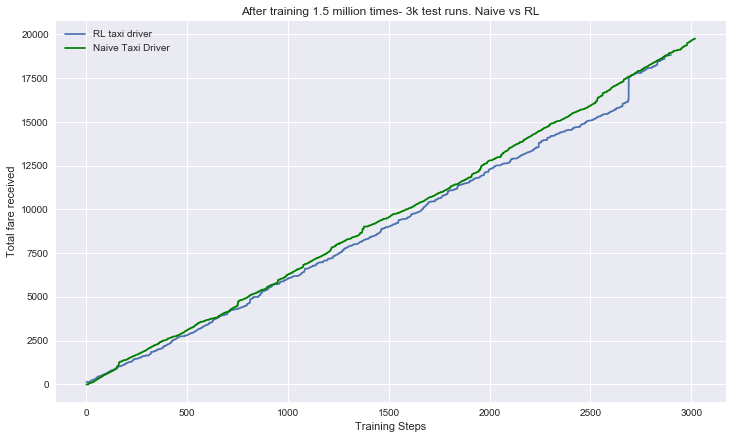

In [36]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_1_5million_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_1_5million_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 1.5 million times- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

# Two million training epochs - MLP DQN (about 3 days of training)

In [304]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model_dqn/model_mlp_linear_2million.h5',
      'save_model_weights':'mlp_linear_2million.h5'} # for the million parameter weights


loss_list_2million, total_fare_received_over_time_2million_training,list_of_geohashes_visited_2million, \
naive_fare_over_time_2million_training, days_driven2million, naive_geohashes_2million =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False, 
                                                   save_model = False)

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 7 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 4.558512210845947
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 500 / STATE observe / EPSILON 0.0001 / ACTION 7 / REWARD 1.07774999989 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 3.2805187702178955
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1000 / STATE observe / EPSILON 0.0001 / ACTION 7 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 2.7866570949554443
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1500 / STATE explore / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  34.1497 / Loss  0.0270860008895 / Total fare RL  3232.88570808 / Total fare naive 2651.83001177
500 steps took 166.57616496

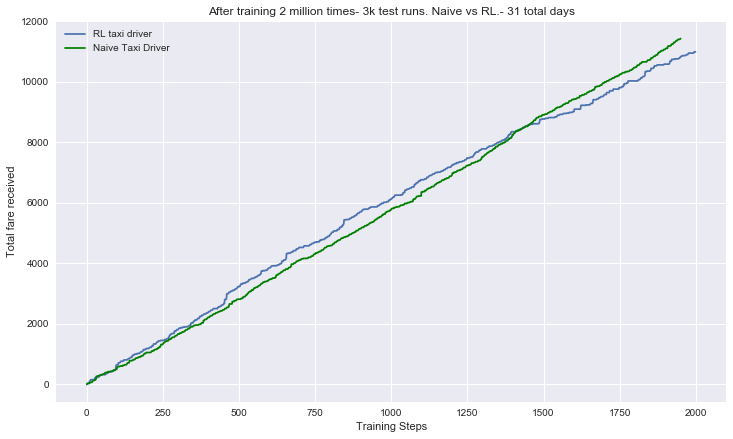

In [311]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_2million_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_2million_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 2 million times- 3k test runs. Naive vs RL.- {} total days'.format(days_driven2million))
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')


In [24]:
print("With two million training examples, we can expect to make this much more {:%}-{:%} per day.".format(
    (6024-5546)/5546,(3156-2672)/2676))


With two million training examples, we can expect to make this much more 8.618824%-18.086697% per day.


# MLP DQN loss after 2 million training epochs
- Every 500 epochs takes about 1 minute

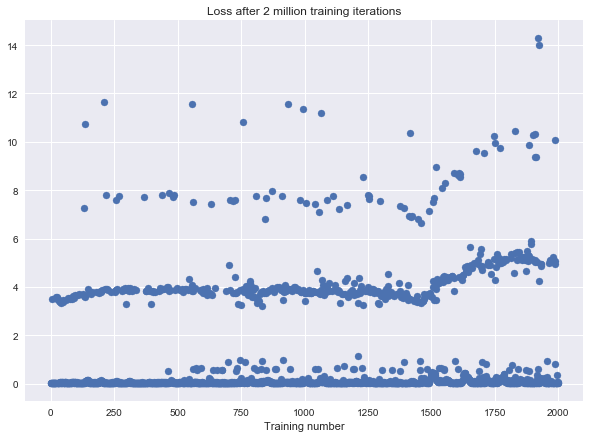

In [313]:
plt.figure(figsize=(10,7))
plt.scatter(np.array([_ for _ in range(len(loss_list_2million))]),np.array(loss_list_2million))
plt.title('Loss after 2 million training iterations')
plt.xlabel('Training number')

- There is probably still room to train the network more as evidenced by the loss above

# DQN - LSTM after 200k training epochs (~5 days of training)
- Every 500 epochs takes ~18 minutes
- The training did not take full advantage of LSTMs beause the data was no trained in a 'sequence'
- With experience replay, random samples from the memory are used as training examples. However, this means that the training examples are not in a sequence.

In [92]:
arg = {'mode':'Run','save_model':False,'model_weights_load':'lstm_model_dqn/lstm_weight_200k.h5',
               'save_model_weights':'lstm_weight_200k.h5'}
train_rl_taxi = RLNYCTaxiCabLargeNetwork_LSTM(list_of_unique_geohashes,list_of_time_index, \
                                              list_of_geohash_index,\
        list_of_inverse_heohash_index, final_data_structure, return_metrics=True)

In [93]:
loss_list_lstm, total_fare_received_over_time_lstm, list_of_geohashes_visited_lstm,\
            naive_fare_over_time_lstm, days_driven_lstm, naive_geohashes_lstm \
                =train_rl_taxi.trainNetworkNeuralNetworkTaxicab_LSTM(arg, training_length=1000,
                            return_training_data = False,
                            save_model= arg ['save_model'])

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 2.0403010845184326
----------Random Action----------
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 500 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 7.915552854537964
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1000 / STATE explore / EPSILON 0.0001 / ACTION 7 / REWARD 0.880833333304 / Q_MAX  1815.21 / Loss  11092.4238281 / Total fare RL  3403.89896279 / Total fare naive 3200.04533953
500 steps took 1488.0928070545197


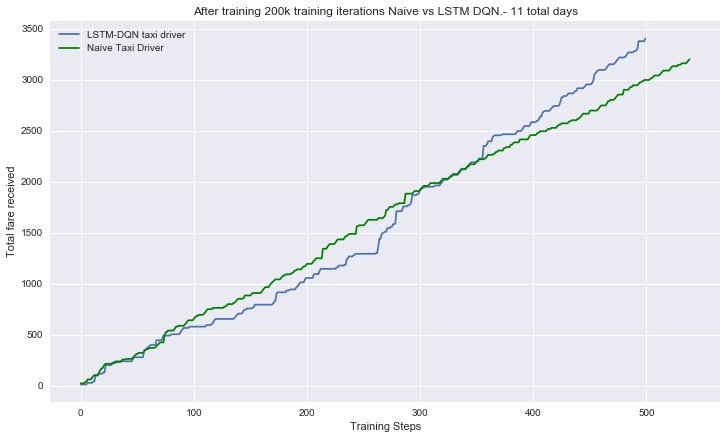

In [94]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_lstm, label = 'LSTM-DQN taxi driver')
plt.plot(naive_fare_over_time_lstm, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 200k training iterations Naive vs LSTM DQN.- {} total days'.format(days_driven_lstm))
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')


### LSTM loss after  200k training iterations

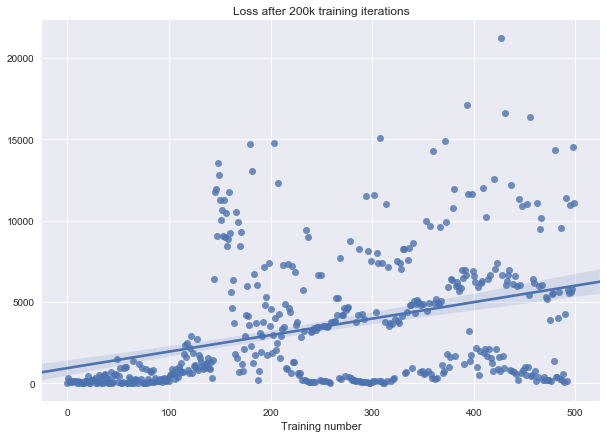

In [96]:
plt.figure(figsize=(10,7))
sns.regplot(np.array([_ for _ in range(len(loss_list_lstm))]),np.array(loss_list_lstm))
plt.title('Loss after 200k training iterations')
plt.xlabel('Training number')

- Loss seems to be increasing, this measn we did not train long enough!

### LSTM loss for entire training period 
- Starting at randomly initialized weights

In [89]:
with open("lstm_model_dqn/loss_over_time_lstm_200k", "rb") as input_file:
     loss_over_time_lstm = pickle.load(input_file)



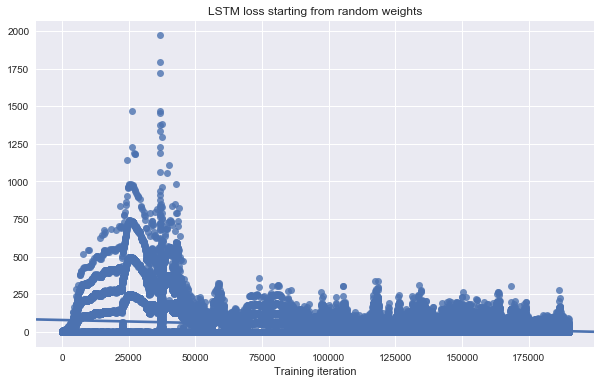

In [97]:
plt.figure(figsize=(10,6))
sns.regplot(np.array([_ for _  in  range(len(loss_over_time_lstm))]),np.array(loss_over_time_lstm))
plt.title('LSTM loss starting from random weights')
plt.xlabel('Training iteration')

# Actor - Critic : MLP after ~350k  training epochs(.5 days)
- Every 500 iterations took ~1.5 minutes
- Each 'day' on average is 77 iterations (or moves)

In [215]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
AC_args = {'mode':'Test','save_model':False,'model_weights_load_actor':'actor_critic_mlp/mlp_actor_updated_25k.h5',
           'model_weights_load_critic':'actor_critic_mlp/mlp_critic_updated_25k.h5',
           'save_model_weights_critic':'mlp_critic.h5',
           'save_model_weights_actor':'mlp_actor.h5','test_buffer_size':50, 'reduce_epsilon_test':True}

In [220]:
actor_critic_model = ActorCriticNYCMLP(AC_args, 9, 2,
                                list_of_unique_geohashes, list_of_time_index,
                                list_of_geohash_index, list_of_inverse_heohash_index,
                                final_data_structure,list_of_output_predictions_to_direction)

In [279]:
actor_loss_AC, critic_loss_AC, AC_fare_over_time, average_fare_per_day_AC,\
        percent_profitable_moves_over_time_AC, naive_fare_over_time_AC,\
        actor_critic_geohashes_visited,naive_geohashes_AC = \
        actor_critic_model.trainer(n_days=20)

Now we load weight
Weight loaded successfully
ONE DAY OVER!
---------METRICS----------
Day #: 1
Wins/Losses 32/121
Percent of moves this day that were profitable 0.20915032679738563
Epsilon is 1e-05
This day took 70.6524658203125
Critic last loss  = [0.00024465309]
Actor last loss = [0.00020366054]
Last Actor-Critic fare = [675.47797880858934]
Last Naive fare = [1081.6075971247215]
--------METIRCS END---------
ONE DAY OVER!
---------METRICS----------
Day #: 2
Wins/Losses 17/51
Percent of moves this day that were profitable 0.25
Epsilon is 1e-05
This day took 9.171348094940186
Critic last loss  = [2.4462224e-05]
Actor last loss = [6.5941844e-05]
Last Actor-Critic fare = [1065.0140303889013]
Last Naive fare = [1471.5616622899936]
--------METIRCS END---------
ONE DAY OVER!
---------METRICS----------
Day #: 3
Wins/Losses 10/21
Percent of moves this day that were profitable 0.3225806451612903
Epsilon is 1e-05
This day took 5.709581136703491
Critic last loss  = [0.026229946]
Actor last loss 

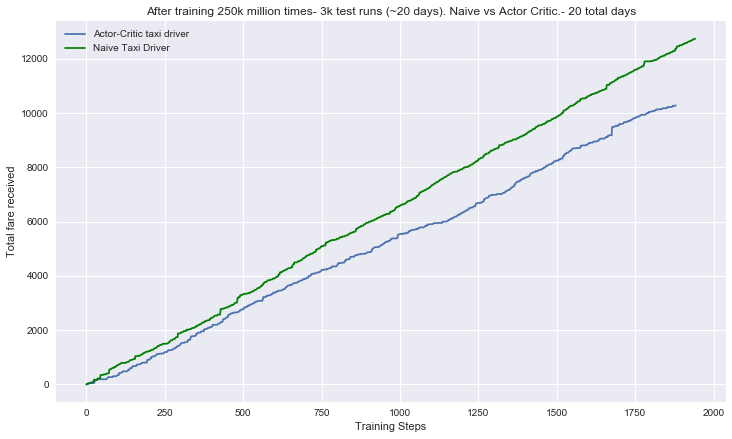

In [280]:
plt.figure(figsize=(12,7))
plt.plot(AC_fare_over_time, label = 'Actor-Critic taxi driver')
plt.plot(naive_fare_over_time, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 250k million times- 3k test runs (~20 days). Naive vs Actor Critic.- {} total days'.format(20))
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')


Ran out of input


## Actor-Critic loss during  the test above

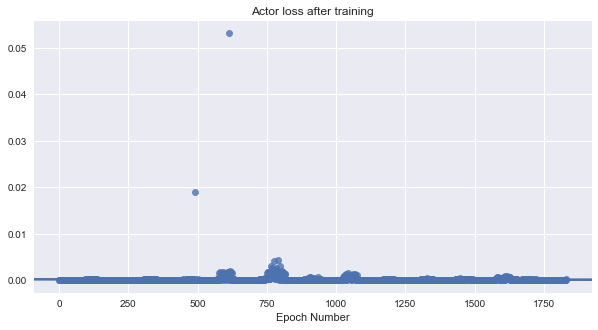

In [288]:
plt.figure(figsize=(10,5))
sns.regplot(np.array([_ for _ in range(len(actor_loss_AC))]),np.array(actor_loss_AC))
plt.title('Actor loss after training')
plt.xlabel('Epoch Number')

### Actor-Critic loss during the entire training process

In [281]:
actor_loss = []
with (open('actor_critic_mlp/actor_loss_new_5k', "rb")) as openfile:

    while True:
        try:
            actor_loss.append(pickle.load(openfile))
        except Exception as e:
            print(e)
            break

Ran out of input


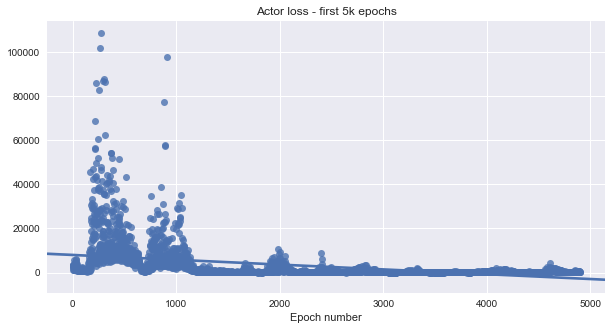

In [282]:
plt.figure(figsize=(10,5))
sns.regplot(np.array([_ for _ in range(len(actor_loss[0][100:5000]))]),np.array(actor_loss[0][100:5000]))
plt.xlabel('Epoch number')
plt.title('Actor loss - first 5k epochs')

- Still some room to reduce the loss by training longer

# Total fare received over one million training examples - DQN - MLP

In [72]:
with open(r"mlp_model_dqn/rl_total_fare_time_linear", "rb") as input_file:
     rl_total_fare_time_linear = pickle.load(input_file)

In [73]:
with open(r"mlp_model_dqn/naive_fare_time_linear", "rb") as input_file:
     naive_fare_time_linear = pickle.load(input_file)

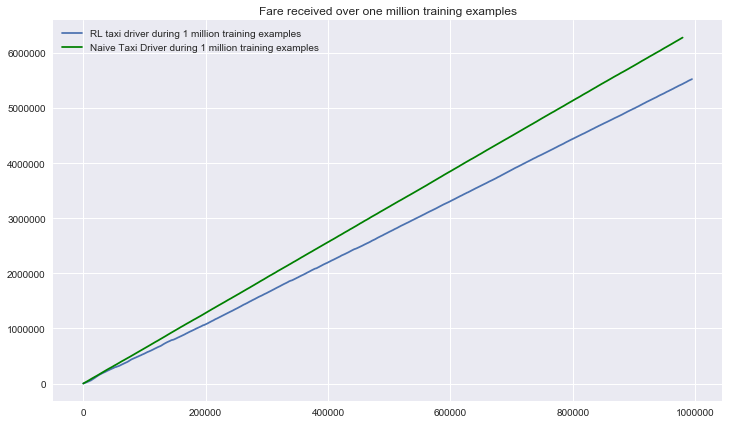

In [76]:
plt.figure(figsize=(12,7))
plt.plot(rl_total_fare_time_linear , label = 'RL taxi driver during 1 million training examples')
plt.plot(naive_fare_time_linear, color='green',label='Naive Taxi Driver during 1 million training examples')
plt.legend()
plt.title('Fare received over one million training examples')

# Visualize the path taken by DQN - Two million training examples, 3k test
- plug these into http://www.gpsvisualizer.com/map_input?form=data

In [244]:
decoded_rl = [gh.decode(i) for i in list_of_geohashes_visited_2million if type(i)!=int]
print('RL path taken')
list_of_rl_path = defaultdict(int)
for line in decoded_rl:
    list_of_rl_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_rl_path.items():
    print('rl',',','rl',',',k[0],k[1],",",v)

RL path taken
rl , rl , 40.696105, -73.954467 , 2
rl , rl , 40.690612, -73.954467 , 4
rl , rl , 40.685119, -73.954467 , 2
rl , rl , 40.679626, -73.954467 , 2
rl , rl , 40.674133, -73.954467 , 3
rl , rl , 40.66864, -73.954467 , 3
rl , rl , 40.663146, -73.954467 , 2
rl , rl , 40.657653, -73.954467 , 1
rl , rl , 40.65216, -73.954467 , 1
rl , rl , 40.646667, -73.954467 , 1
rl , rl , 40.641174, -73.954467 , 1
rl , rl , 40.635681, -73.954467 , 2
rl , rl , 40.630187, -73.954467 , 1
rl , rl , 40.624694, -73.954467 , 1
rl , rl , 40.619201, -73.954467 , 1
rl , rl , 40.613708, -73.954467 , 1
rl , rl , 40.608215, -73.954467 , 1
rl , rl , 40.602722, -73.954467 , 1
rl , rl , 40.597229, -73.954467 , 1
rl , rl , 40.591735, -73.954467 , 1
rl , rl , 40.586242, -73.954467 , 1
rl , rl , 40.580749, -73.954467 , 1
rl , rl , 40.575256, -73.954467 , 1
rl , rl , 40.569763, -73.954467 , 1
rl , rl , 40.729064, -73.987426 , 58
rl , rl , 40.723571, -73.987426 , 55
rl , rl , 40.718078, -73.987426 , 52
rl , rl , 40.

In [261]:
decoded_naive = [gh.decode(i) for i in naive_geohashes_2million if type(i)!=int]
print('Naive path taken')
list_of_naive_path = defaultdict(int)
for line in decoded_naive:
    list_of_naive_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_naive_path.items():
    print('naive',',','naive',',',k[0],k[1],",",v)

Naive path taken
naive , naive , 40.740051, -73.97644 , 80
naive , naive , 40.844421, -73.833618 , 1
naive , naive , 40.844421, -73.844604 , 1
naive , naive , 40.838928, -73.844604 , 1
naive , naive , 40.833435, -73.85559 , 1
naive , naive , 40.729064, -73.998413 , 82
naive , naive , 40.723571, -73.987426 , 39
naive , naive , 40.718078, -73.987426 , 18
naive , naive , 40.712585, -73.97644 , 9
naive , naive , 40.745544, -73.97644 , 41
naive , naive , 40.745544, -73.965454 , 38
naive , naive , 40.740051, -73.965454 , 51
naive , naive , 40.729064, -73.987426 , 90
naive , naive , 40.734558, -73.987426 , 56
naive , naive , 40.734558, -73.965454 , 53
naive , naive , 40.740051, -73.954467 , 33
naive , naive , 40.734558, -73.97644 , 83
naive , naive , 40.745544, -73.987426 , 57
naive , naive , 40.740051, -73.998413 , 74
naive , naive , 40.751037, -73.97644 , 17
naive , naive , 40.745544, -73.954467 , 29
naive , naive , 40.740051, -73.943481 , 21
naive , naive , 40.745544, -73.932495 , 10
naive

# Visualize path taken by LSTM

In [102]:


decoded_lstm = [gh.decode(i) for i in list_of_geohashes_visited_lstm if type(i)!=int]
print('Lstm path taken')
list_of_lstm_path = defaultdict(int)
for line in decoded_lstm:
    list_of_lstm_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_lstm_path.items():
    print('lstm',',','lstm',',',k[0],k[1],",",v)

Lstm path taken
lstm , lstm , 40.437927, -74.09729 , 1
lstm , lstm , 40.44342, -74.09729 , 1
lstm , lstm , 40.448913, -74.09729 , 1
lstm , lstm , 40.740051, -73.987426 , 26
lstm , lstm , 40.745544, -73.987426 , 24
lstm , lstm , 40.751037, -73.987426 , 23
lstm , lstm , 40.75653, -73.987426 , 21
lstm , lstm , 40.762023, -73.987426 , 21
lstm , lstm , 40.767517, -73.987426 , 21
lstm , lstm , 40.77301, -73.987426 , 21
lstm , lstm , 40.778503, -73.987426 , 20
lstm , lstm , 40.783996, -73.987426 , 20
lstm , lstm , 40.789489, -73.987426 , 20
lstm , lstm , 40.794982, -73.987426 , 20
lstm , lstm , 40.800476, -73.987426 , 18
lstm , lstm , 40.805969, -73.987426 , 18
lstm , lstm , 40.811462, -73.987426 , 18
lstm , lstm , 40.816955, -73.987426 , 17
lstm , lstm , 40.822448, -73.987426 , 17
lstm , lstm , 40.827941, -73.987426 , 16
lstm , lstm , 40.833435, -73.987426 , 15
lstm , lstm , 40.838928, -73.987426 , 15
lstm , lstm , 40.844421, -73.987426 , 15
lstm , lstm , 40.849914, -73.987426 , 15
lstm , ls

In [108]:


decoded_lstm_naive = [gh.decode(i) for i in naive_geohashes_lstm if type(i)!=int]
print('Lstm path taken')
list_of_lstm_naive_path = defaultdict(int)
for line in decoded_lstm_naive:
    list_of_lstm_naive_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_lstm_naive_path.items():
    print('lstm- niave',',','lstm',',',k[0],k[1],",",v)

Lstm path taken
lstm- niave , lstm , 40.696105, -73.998413 , 1
lstm- niave , lstm , 40.696105, -73.987426 , 1
lstm- niave , lstm , 40.740051, -73.987426 , 12
lstm- niave , lstm , 40.734558, -73.998413 , 27
lstm- niave , lstm , 40.729064, -74.009399 , 13
lstm- niave , lstm , 40.729064, -73.998413 , 19
lstm- niave , lstm , 40.723571, -73.987426 , 13
lstm- niave , lstm , 40.729064, -73.97644 , 26
lstm- niave , lstm , 40.729064, -73.987426 , 33
lstm- niave , lstm , 40.734558, -73.987426 , 22
lstm- niave , lstm , 40.723571, -74.009399 , 11
lstm- niave , lstm , 40.723571, -74.020385 , 3
lstm- niave , lstm , 40.723571, -73.998413 , 5
lstm- niave , lstm , 40.718078, -74.020385 , 1
lstm- niave , lstm , 40.729064, -74.020385 , 6
lstm- niave , lstm , 40.740051, -73.97644 , 14
lstm- niave , lstm , 40.745544, -73.998413 , 6
lstm- niave , lstm , 40.745544, -74.009399 , 4
lstm- niave , lstm , 40.745544, -74.020385 , 4
lstm- niave , lstm , 40.751037, -74.020385 , 3
lstm- niave , lstm , 40.740051, -74.

# Visualize the path taken by Actor Critic

In [293]:

decoded_ac_mlp = [gh.decode(i) for i in actor_critic_geohashes_visited if type(i)!=int]
print('AC - MLP path taken')
list_of_ac_mlp_path = defaultdict(int)
for line in decoded_ac_mlp:
    list_of_ac_mlp_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_ac_mlp_path.items():
    print('AC MLP',',','AC MLP',',',k[0],k[1],",",v)

AC - MLP path taken
AC MLP , AC MLP , 41.141052, -73.295288 , 1
AC MLP , AC MLP , 41.146545, -73.295288 , 1
AC MLP , AC MLP , 40.740051, -73.987426 , 3
AC MLP , AC MLP , 40.745544, -73.987426 , 3
AC MLP , AC MLP , 40.751037, -73.987426 , 3
AC MLP , AC MLP , 40.75653, -73.987426 , 2
AC MLP , AC MLP , 40.762023, -73.987426 , 2
AC MLP , AC MLP , 40.767517, -73.987426 , 2
AC MLP , AC MLP , 40.77301, -73.987426 , 3
AC MLP , AC MLP , 40.778503, -73.987426 , 2
AC MLP , AC MLP , 40.783996, -73.987426 , 2
AC MLP , AC MLP , 40.789489, -73.987426 , 2
AC MLP , AC MLP , 40.794982, -73.987426 , 2
AC MLP , AC MLP , 40.800476, -73.987426 , 2
AC MLP , AC MLP , 40.805969, -73.987426 , 2
AC MLP , AC MLP , 40.811462, -73.987426 , 2
AC MLP , AC MLP , 40.816955, -73.987426 , 2
AC MLP , AC MLP , 40.822448, -73.987426 , 2
AC MLP , AC MLP , 40.827941, -73.987426 , 2
AC MLP , AC MLP , 40.833435, -73.987426 , 2
AC MLP , AC MLP , 40.838928, -73.987426 , 2
AC MLP , AC MLP , 40.844421, -73.987426 , 2
AC MLP , AC ML

In [294]:

decoded_ac_naive = [gh.decode(i) for i in naive_geohashes_AC if type(i)!=int]
print('AC NAive path taken')
list_of_ac_naive_path = defaultdict(int)
for line in decoded_ac_naive:
    list_of_ac_naive_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_ac_naive_path.items():
    print('AC NAIVE',',','AC NAIVE',',',k[0],k[1],",",v)

AC NAive path taken
AC NAIVE , AC NAIVE , 41.141052, -73.295288 , 1
AC NAIVE , AC NAIVE , 40.729064, -73.998413 , 60
AC NAIVE , AC NAIVE , 40.729064, -74.009399 , 20
AC NAIVE , AC NAIVE , 40.723571, -74.009399 , 21
AC NAIVE , AC NAIVE , 40.740051, -73.987426 , 86
AC NAIVE , AC NAIVE , 40.740051, -73.998413 , 56
AC NAIVE , AC NAIVE , 40.734558, -73.987426 , 50
AC NAIVE , AC NAIVE , 40.740051, -73.97644 , 58
AC NAIVE , AC NAIVE , 40.734558, -73.97644 , 61
AC NAIVE , AC NAIVE , 40.745544, -73.97644 , 40
AC NAIVE , AC NAIVE , 40.751037, -73.987426 , 17
AC NAIVE , AC NAIVE , 40.75653, -73.998413 , 8
AC NAIVE , AC NAIVE , 40.75653, -73.987426 , 7
AC NAIVE , AC NAIVE , 40.745544, -73.987426 , 39
AC NAIVE , AC NAIVE , 40.745544, -73.998413 , 26
AC NAIVE , AC NAIVE , 40.751037, -73.998413 , 13
AC NAIVE , AC NAIVE , 40.745544, -74.009399 , 29
AC NAIVE , AC NAIVE , 40.734558, -73.965454 , 39
AC NAIVE , AC NAIVE , 40.729064, -73.97644 , 48
AC NAIVE , AC NAIVE , 40.729064, -73.965454 , 21
AC NAIVE 

In [ ]:
naive_geohashes_AC

# Real time visualization of each algorithm and naive approach on a NYC map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b

30.8384850025177 seconds


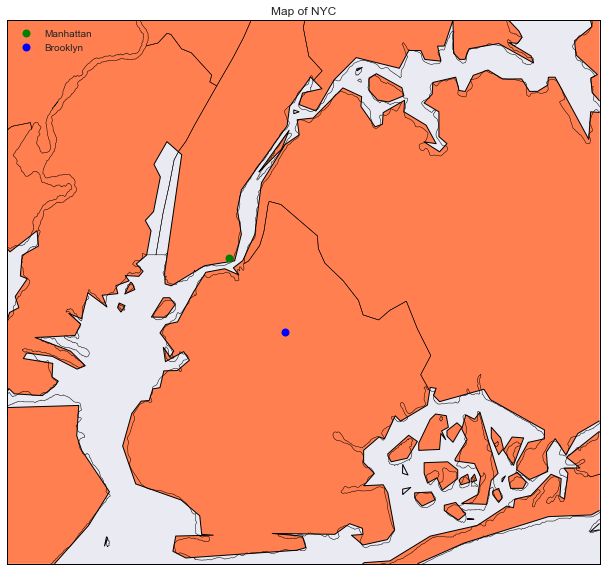

In [190]:

start = time.time()
my_map = Basemap(projection='merc', lat_0=40.727324, lon_0=-73.979187,
    resolution = 'h', area_thresh = 0.00001,
    llcrnrlon=-74.116516 , llcrnrlat=40.569029,
    urcrnrlon=-73.749161, urcrnrlat=40.82464)

#40.569029,-74.116516  lower left, lat, long
#40.82464,-73.749161, upper right NYC, lat long
#40.727324,-73.979187, Center NYC lat long

plt.figure(figsize=(15,10))
my_map.drawcoastlines()
#my_map.drawcountries()
my_map.fillcontinents(color='coral')
my_map.drawmapboundary()
my_map.drawrivers()
 
### getter better resolution map with shape files
#my_map.readshapefile('shape_files/USA_adm0','USA0')
#my_map.readshapefile("shape_files/USA_adm1",'USA1')
my_map.readshapefile("shape_files/USA_adm2",'USA2')

#my_map.drawmeridians(np.arange(0, 360, 30))
#my_map.drawparallels(np.arange(-90, 90, 30))

#### plot the center of NYC
lon_nyc = -73.979187
lat_nyc = 40.712784,
x_nyc, y_nyc = my_map(lon_nyc, lat_nyc)
my_map.plot(x_nyc, y_nyc, 'go', markersize=8, label='Manhattan')
#### plot the center of brooklyn
lat_brooklyn = 40.678178
lon_brooklyn = -73.944158
x_brooklyn, y_brooklyn = my_map(lon_brooklyn, lat_brooklyn)
my_map.plot(x_brooklyn, y_brooklyn, 'bo', markersize=8, label='Brooklyn')

end = time.time()
plt.legend()
plt.title('Map of NYC')
print(end-start , 'seconds')

 

 

In [302]:
# start point Midtown
# JFK : ZcvQ1
# Midtown - Moma: Zct9Y

In [394]:
args = {'model_weights_load_actor_mlp':'actor_critic_mlp/mlp_actor_updated_25k.h5',
         'model_weights_load_dqn_mlp':'mlp_model_dqn/model_mlp_linear_2million.h5',
         'model_weights_load_dqn_lstm':'lstm_model_dqn/lstm_weight_200k.h5'}

In [395]:
algorithm_comparison = AlgorithmComparison(args, 9, 2, list_of_unique_geohashes, list_of_time_index,
                                           list_of_geohash_index,
                                           list_of_inverse_heohash_index, final_data_structure, 
                                           list_of_output_predictions_to_direction)

Loading weights for Actor model
Weights loaded for Actor model
Loading weights for MLP DQN
Weights loaded for MLP DQN
Loading weights for LSTM DQN
Weights loaded for LSTM DQN


# Test having all algorithms start at Midtown near the MoMa

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b

25.095738887786865 seconds
Total fare DQN MLP so far = 15.87
Total fare DQN LSTM so far = 11.61
Total fare Naive so far = 12.44
Total fare Actor Critic so far = 9.64


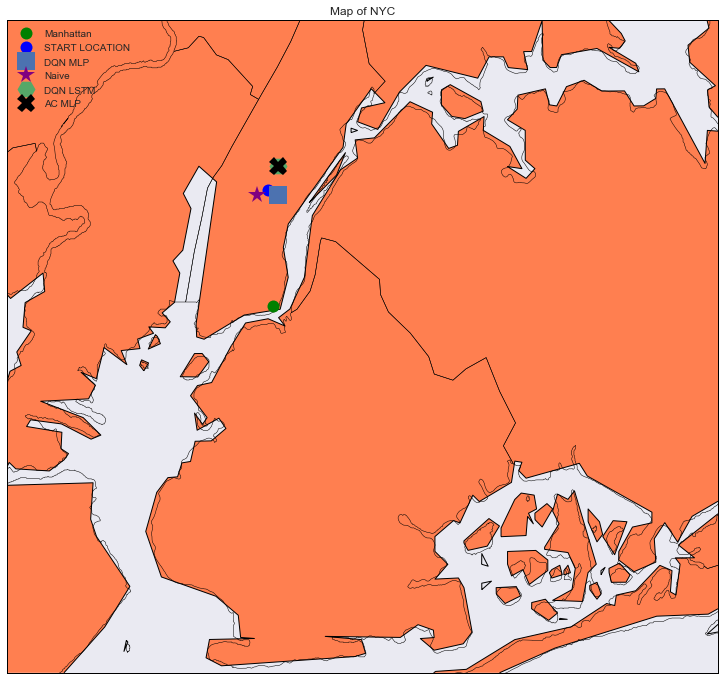

21.005746841430664 seconds
Total fare DQN MLP so far = 26.28
Total fare DQN LSTM so far = 25.75
Total fare Naive so far = 22.37
Total fare Actor Critic so far = 24.06


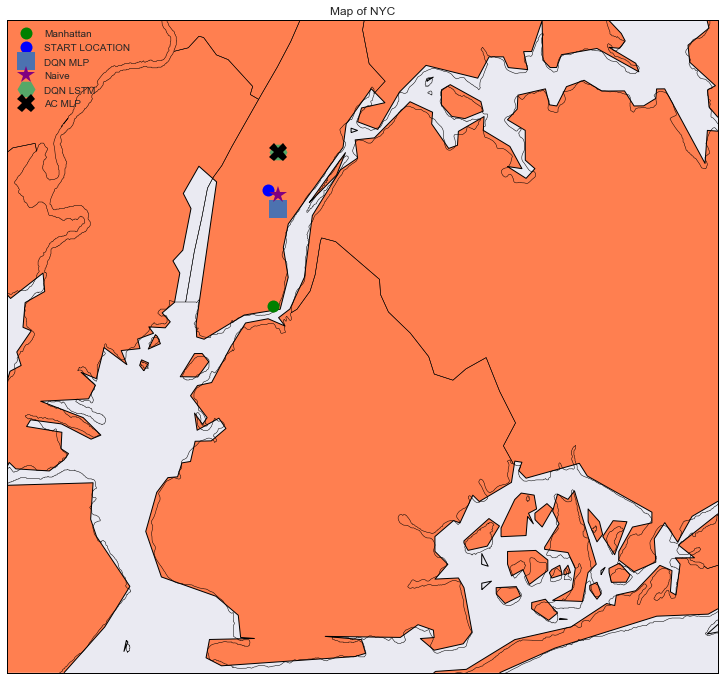

21.867568016052246 seconds
Total fare DQN MLP so far = 38.29
Total fare DQN LSTM so far = 38.79
Total fare Naive so far = 22.37
Total fare Actor Critic so far = 36.55


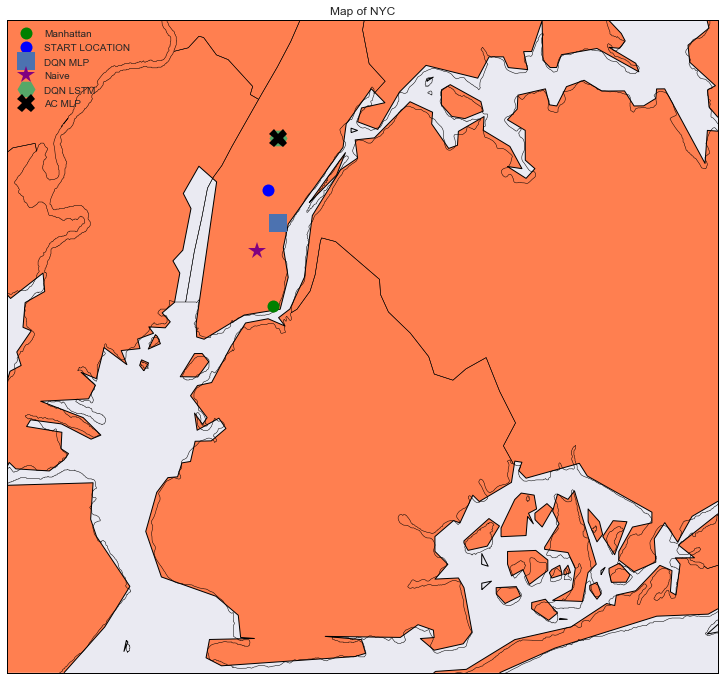

23.33774995803833 seconds
Total fare DQN MLP so far = 50.80
Total fare DQN LSTM so far = 51.75
Total fare Naive so far = 38.37
Total fare Actor Critic so far = 52.08


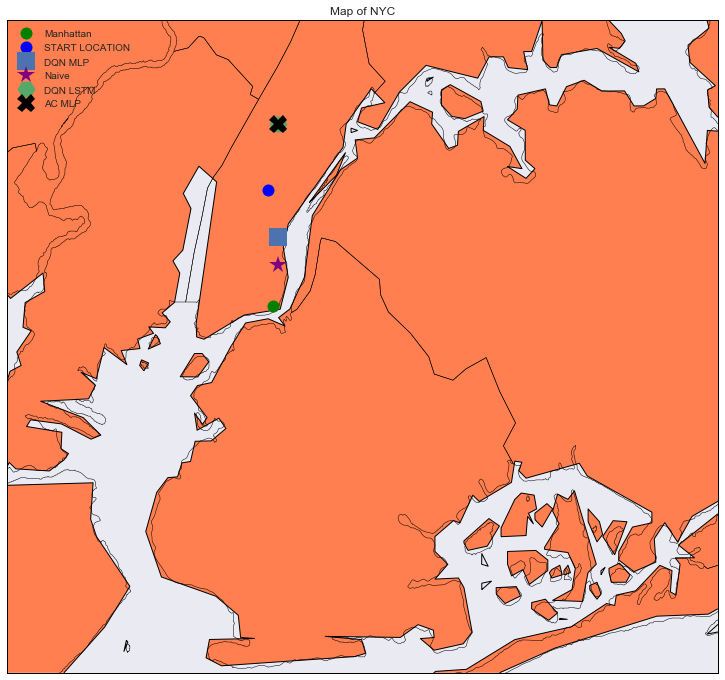

20.640138149261475 seconds
Total fare DQN MLP so far = 50.80
Total fare DQN LSTM so far = 64.92
Total fare Naive so far = 38.37
Total fare Actor Critic so far = 52.08


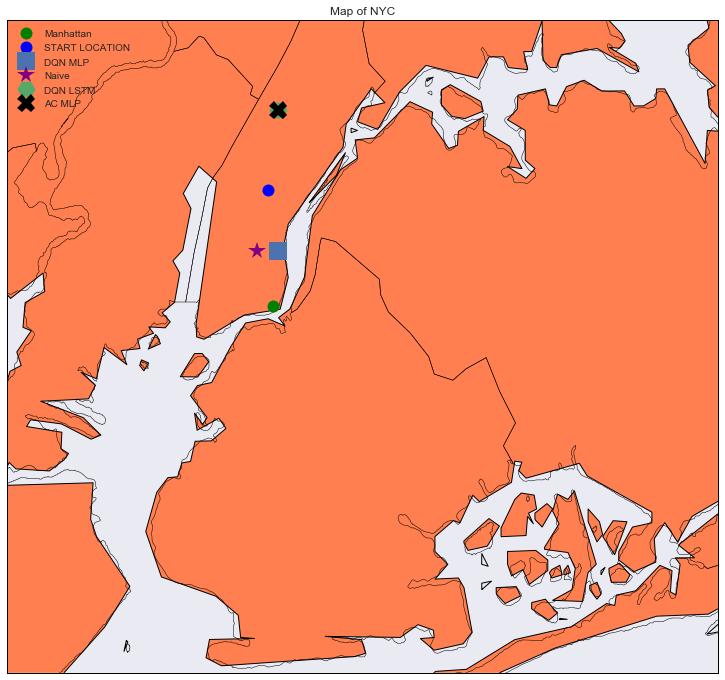

In [400]:


total_fare_dqn_mlp = 0
total_fare_naive = 0
total_fare_dqn_lstm = 0
total_fare_actor_critic_mlp = 0



for i in range(5):
    start = time.time()
    if i == 0:
        # Get Lat and long and fare for each algorithm
        latitude_s1_dqn_mlp, longtitude_s1_dqn_mlp, fare_t_dqn_mlp,\
                latitude_s1_dqn_lstm, longtitude_s1_dqn_lstm, fare_t_dqn_lstm,\
                latitude_s1_ac_mlp, longtitude_s1_ac_mlp, fare_t_ac_mlp,\
                latitude_s1_naive, longtitude_s1_naive, fare_t_naive= \
        algorithm_comparison.output_lat_long_predictions_given_input(geohash_start='Zct9Y', 
                                                                         time_start=800, first_run=True)
        # Keep track of fares received
        total_fare_dqn_mlp += fare_t_dqn_mlp
        total_fare_naive += fare_t_naive
        total_fare_dqn_lstm += fare_t_dqn_lstm
        total_fare_actor_critic_mlp+= fare_t_ac_mlp
        
        ### Create the entire map
        my_map = Basemap(projection='merc', lat_0=40.727324, lon_0=-73.979187,
        resolution = 'h', area_thresh = 0.00001,
        llcrnrlon=-74.116516 , llcrnrlat=40.569029,
        urcrnrlon=-73.749161, urcrnrlat=40.82464)

        #40.569029,-74.116516  lower left, lat, long
        #40.82464,-73.749161, upper right NYC, lat long
        #40.727324,-73.979187, Center NYC lat long

        plt.figure(figsize=(18,12))
        my_map.drawcoastlines()
        #my_map.drawcountries()
        my_map.fillcontinents(color='coral')
        my_map.drawmapboundary()
        my_map.drawrivers()

        ### getter better resolution map with shape files
        #my_map.readshapefile('shape_files/USA_adm0','USA0')
        #my_map.readshapefile("shape_files/USA_adm1",'USA1')
        my_map.readshapefile("shape_files/USA_adm2",'USA2')

        #my_map.drawmeridians(np.arange(0, 360, 30))
        #my_map.drawparallels(np.arange(-90, 90, 30))

        #### plot the center of NYC
        lon_nyc = -73.979187
        lat_nyc = 40.712784,
        x_nyc, y_nyc = my_map(lon_nyc, lat_nyc)
        my_map.plot(x_nyc, y_nyc, 'go', markersize=12, label='Manhattan')
        #### plot the start
#         lat_start = 40.652733 # JFK
#         lon_start = -73.793106 # JFK
        lat_start = 40.75816
        lon_start = -73.981762
        x_start, y_start = my_map(lon_start, lat_start)
        my_map.plot(x_start, y_start, 'bo', markersize=12, label='START LOCATION')

        # plot MLP DQN
        lat_dqn_mlp = latitude_s1_dqn_mlp
        lon_dqn_mlp = longtitude_s1_dqn_mlp
        x_dqn_mlp, y_dqn_mlp = my_map(lon_dqn_mlp, lat_dqn_mlp)
        my_map.plot(x_dqn_mlp, y_dqn_mlp, 's', markersize=18, label='DQN MLP')

        # Plot Naive
        lat_naive = latitude_s1_naive
        lon_naive = longtitude_s1_naive
        x_naive, y_naive = my_map(lon_naive, lat_naive)
        my_map.plot(x_naive, y_naive, '*', markersize=18, label='Naive',color='purple')

        # Plot LSTM DQN
        lat_dqn_lstm = latitude_s1_dqn_lstm
        lon_dqn_lstm = longtitude_s1_dqn_lstm
        x_dqn_lstm, y_dqn_lstm = my_map(lon_dqn_lstm, lat_dqn_lstm)
        my_map.plot(x_dqn_lstm, y_dqn_lstm, 'H', markersize=18, label='DQN LSTM')
        
        # Plot Actor Critic
        lat_ac_mlp = latitude_s1_ac_mlp
        lon_ac_mlp = longtitude_s1_ac_mlp
        x_ac_mlp, y_ac_mlp = my_map(lon_ac_mlp, lat_ac_mlp)
        my_map.plot(x_ac_mlp, y_ac_mlp, 'X', markersize=18, label='AC MLP', color ='black')
        
        end = time.time()
        plt.title('Map of NYC')
        print(end-start , 'seconds')
        plt.legend()
        print('Total fare DQN MLP so far = {:,.2f}'.format(total_fare_dqn_mlp)) 
        print('Total fare DQN LSTM so far = {:,.2f}'.format(total_fare_dqn_lstm )) 
        print('Total fare Naive so far = {:,.2f}'.format(total_fare_naive)) 
        print('Total fare Actor Critic so far = {:,.2f}'.format(total_fare_actor_critic_mlp)) 
        

        plt.show()
        
    else:
        # Get Lat and long and fare for each algorithm
        latitude_s1_dqn_mlp, longtitude_s1_dqn_mlp, fare_t_dqn_mlp,\
                latitude_s1_dqn_lstm, longtitude_s1_dqn_lstm, fare_t_dqn_lstm,\
                latitude_s1_ac_mlp, longtitude_s1_ac_mlp, fare_t_ac_mlp,\
                latitude_s1_naive, longtitude_s1_naive, fare_t_naive= \
        algorithm_comparison.output_lat_long_predictions_given_input()
        
        # keep track of total fare received
        total_fare_dqn_mlp += fare_t_dqn_mlp
        total_fare_naive += fare_t_naive
        total_fare_dqn_lstm += fare_t_dqn_lstm
        total_fare_actor_critic_mlp+= fare_t_ac_mlp

        #### Create the map
        my_map = Basemap(projection='merc', lat_0=40.727324, lon_0=-73.979187,
        resolution = 'h', area_thresh = 0.00001,
        llcrnrlon=-74.116516 , llcrnrlat=40.569029,
        urcrnrlon=-73.749161, urcrnrlat=40.82464)

        #40.569029,-74.116516  lower left, lat, long
        #40.82464,-73.749161, upper right NYC, lat long
        #40.727324,-73.979187, Center NYC lat long
    
        plt.figure(figsize=(18,12))
        my_map.drawcoastlines()
        #my_map.drawcountries()
        my_map.fillcontinents(color='coral')
        my_map.drawmapboundary()
        my_map.drawrivers()

        ### getter better resolution map with shape files
        #my_map.readshapefile('shape_files/USA_adm0','USA0')
        #my_map.readshapefile("shape_files/USA_adm1",'USA1')
        my_map.readshapefile("shape_files/USA_adm2",'USA2')

        #my_map.drawmeridians(np.arange(0, 360, 30))
        #my_map.drawparallels(np.arange(-90, 90, 30))

        #### plot the center of NYC
        lon_nyc = -73.979187
        lat_nyc = 40.712784,
        x_nyc, y_nyc = my_map(lon_nyc, lat_nyc)
        my_map.plot(x_nyc, y_nyc, 'go', markersize=12, label='Manhattan')
         #### plot the start
#         lat_start = 40.652733 # JFK
#         lon_start = -73.793106 # JFK
        lat_start = 40.75816
        lon_start = -73.981762
        x_start, y_start = my_map(lon_start, lat_start)
        my_map.plot(x_start, y_start, 'bo', markersize=12, label='START LOCATION')

        # plot MLP DQN
        lat_dqn_mlp = latitude_s1_dqn_mlp
        lon_dqn_mlp = longtitude_s1_dqn_mlp
        x_dqn_mlp, y_dqn_mlp = my_map(lon_dqn_mlp, lat_dqn_mlp)
        my_map.plot(x_dqn_mlp, y_dqn_mlp, 's', markersize=18, label='DQN MLP')

        # Plot Naive
        lat_naive = latitude_s1_naive
        lon_naive = longtitude_s1_naive
        x_naive, y_naive = my_map(lon_naive, lat_naive)
        my_map.plot(x_naive, y_naive, '*', markersize=18, label='Naive',color='purple')

        # Plot LSTM DQN
        lat_dqn_lstm = latitude_s1_dqn_lstm
        lon_dqn_lstm = longtitude_s1_dqn_lstm
        x_dqn_lstm, y_dqn_lstm = my_map(lon_dqn_lstm, lat_dqn_lstm)
        my_map.plot(x_dqn_lstm,y_dqn_lstm , 'H', markersize=18, label='DQN LSTM')
        
        # Plot Actor Critic
        lat_ac_mlp = latitude_s1_ac_mlp
        lon_ac_mlp = longtitude_s1_ac_mlp
        x_ac_mlp, y_ac_mlp = my_map(lon_ac_mlp, lat_ac_mlp)
        my_map.plot(x_ac_mlp, y_ac_mlp, 'X', markersize=18, label='AC MLP', color = 'black')


        end = time.time()
        plt.title('Map of NYC')
        print(end-start , 'seconds')
        plt.legend()
        print('Total fare DQN MLP so far = {:,.2f}'.format(total_fare_dqn_mlp)) 
        print('Total fare DQN LSTM so far = {:,.2f}'.format(total_fare_dqn_lstm )) 
        print('Total fare Naive so far = {:,.2f}'.format(total_fare_naive)) 
        print('Total fare Actor Critic so far = {:,.2f}'.format(total_fare_actor_critic_mlp)) 

        
        plt.show()

 

 

- Interesting that AC MLP and LSTM DQN have tlearned the same policy. This is probably due to not training these models long enough!

### Over 3,000 'moves' compare what the DQN-MLP model looks like to a naive implementation


#### DQN-MLP
<img src="../figures/rl_pathtaken_viz_2million.png">

### Naive implementation

<img src ="../figures/naive_pathtaken_viz.png">

# Over, 1,000 epochs, compare LSTM to naive implementation

## LSTM implementation
<img src ="../figures/lstm_visualization_1k.png">

## Naive/Random implementation
<img src ="../figures/lstm_naive_viz_1k.png">

# Compare Actor Critic to a naive approach

## Actor Critic Path Taken
<img src ="../figures/actor_critic_viz_350k.png">

## Naive appraoch - Actor Critic - Path Taken

<img src ="../figures/actor_critic_naive_viz_450k.png">